In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import sys
sys.path.append('../ca2-mec')
import data_processing as dp
from trackunitmulticomparison import TrackMultipleSessions
from registration import store_notebook
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import quantities as pq
import exdir
from distutils.dir_util import copy_tree
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
import networkx as nx
#from nxpd import draw
%matplotlib inline

In [3]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

identify_neurons = project.require_action('identify-neurons')
data_loader = dp.Data()

In [7]:
include = ['011-120321-2', '011-120321-3', '011-120321-4', '011-120321-5', '011-120321-6']

# find the complement of include
skip_actions = []
for action in actions:
    if action not in include:
        skip_actions.append(action)
skip_actions, include

(['002-050721-3',
  '002-050721-2',
  '001-280721-3',
  '145-141021-2',
  '011-surgery-implantation',
  '002-050721-1',
  '145-141021-4',
  '001-280721-5',
  '145-141021-5',
  '137-230121-6',
  '001-280721-1',
  '137-230121-3',
  '001-290721-2',
  '145-141021-3',
  '145-141021-6',
  '002-050721-5',
  '011-adjustment',
  '001-290721-1',
  '002-050721-4',
  '001-290721-3',
  'identify-neurons',
  '001-280721-4',
  '137-230121-5',
  '137-230121-2',
  '145-141021-1',
  '001-280721-2',
  '137-230121-4'],
 ['011-120321-2',
  '011-120321-3',
  '011-120321-4',
  '011-120321-5',
  '011-120321-6'])

In [8]:
sessions = []
for action in actions.values():
    if action.id in skip_actions:
        continue
    if action.type != 'Recording':
        continue
    print(action.id)
    action_data_path = dp.get_data_path(action)
    exdir_object =  exdir.File(action_data_path)
    if 'processing' not in exdir_object:
        continue
        
    processing = exdir_object['processing']
    
    if not 'electrophysiology' in processing:
        continue
    elphys = processing['electrophysiology']
    if 'spikesorting' not in elphys:
        continue  

    sessions.append({
       'action': action.id,
       'session': int(action.id.split('-')[-1]),
       'entity': action.entities[0],

   })
sessions = pd.DataFrame(sessions)

011-120321-2
011-120321-6
011-120321-3
011-120321-4
011-120321-5


In [9]:
sessions['date'] = sessions.apply(lambda x: x.action.split('-')[1], axis=1)
sessions['entity_date'] = sessions.apply(lambda x: '-'.join(x.action.split('-')[:2]), axis=1)
sessions.to_csv(identify_neurons.data_path() / 'sessions.csv', index=False)
sessions

,action,session,entity,date,entity_date
0,011-120321-2,2,011,120321,011-120321
1,011-120321-6,6,011,120321,011-120321
2,011-120321-3,3,011,120321,011-120321
3,011-120321-4,4,011,120321,011-120321
4,011-120321-5,5,011,120321,011-120321


# Identify unique neurons

In [10]:
sessions_include = sessions.query("action.isin(@include)")
sessions_include

,action,session,entity,date,entity_date
0,011-120321-2,2,011,120321,011-120321
1,011-120321-6,6,011,120321,011-120321
2,011-120321-3,3,011,120321,011-120321
3,011-120321-4,4,011,120321,011-120321
4,011-120321-5,5,011,120321,011-120321


In [11]:
# save graphs
for entity, values in sessions_include.groupby('entity'):
    print(entity, values)
    data_path = identify_neurons.data_path() / f'{entity}-graphs'
    if data_path.exists():
        shutil.rmtree(data_path)
#         continue
    unit_matching = TrackMultipleSessions(
        actions, action_list=values.action.values.tolist(), 
        progress_bar=tqdm, verbose=False, data_path=data_path
    )
    unit_matching.do_matching()
    unit_matching.make_graphs_from_matches()
#     unit_matching.compute_time_delta_edges()
    unit_matching.compute_depth_delta_edges()
    # save graph with all dissimilarities for later use
    unit_matching.save_graphs()

011          action  session entity    date entity_date
0  011-120321-2        2    011  120321  011-120321
1  011-120321-6        6    011  120321  011-120321
2  011-120321-3        3    011  120321  011-120321
3  011-120321-4        4    011  120321  011-120321
4  011-120321-5        5    011  120321  011-120321


  0%|          | 0/10 [00:00<?, ?it/s]

# Plot comparisons

In [12]:
entity = "011"
unit_comp = TrackMultipleSessions(
    actions, sessions_include.action.values, data_path=identify_neurons.data_path() / f'{entity}-graphs')

unit_comp.load_graphs()

In [13]:
max_dissimilarity = .05
max_depth_delta = 100

unit_comp.remove_edges_above_threshold('weight', max_dissimilarity)
unit_comp.remove_edges_above_threshold('depth_delta', max_depth_delta)

unit_comp.remove_edges_with_duplicate_actions()
unit_comp.identify_units()

Zero units found on channel group 0
Zero units found on channel group 2
Zero units found on channel group 4
Zero units found on channel group 5
Zero units found on channel group 6
Zero units found on channel group 7


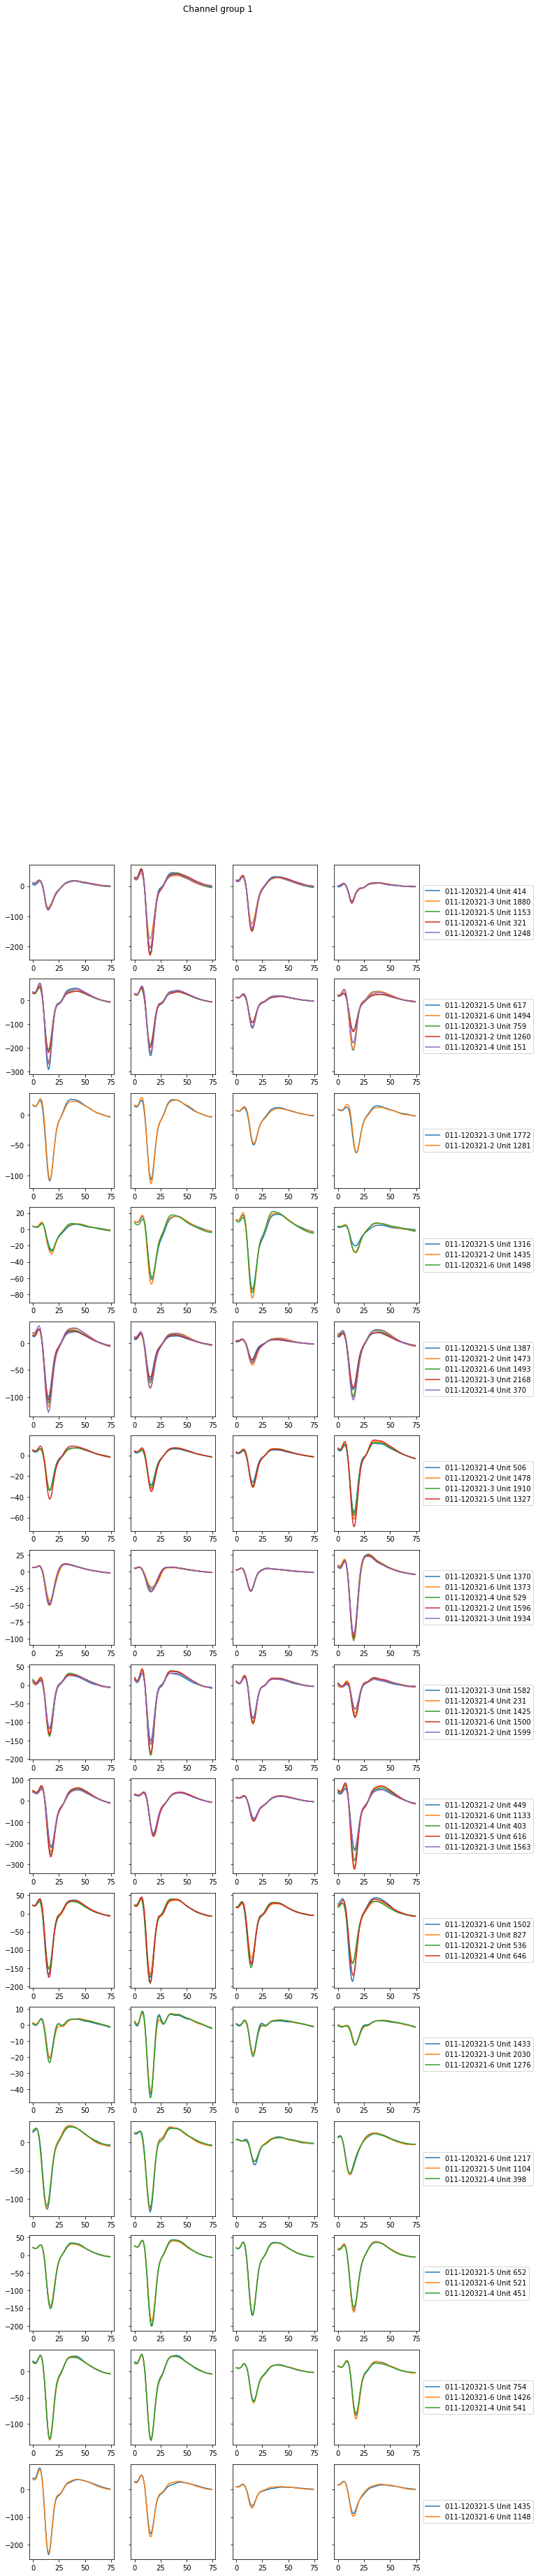

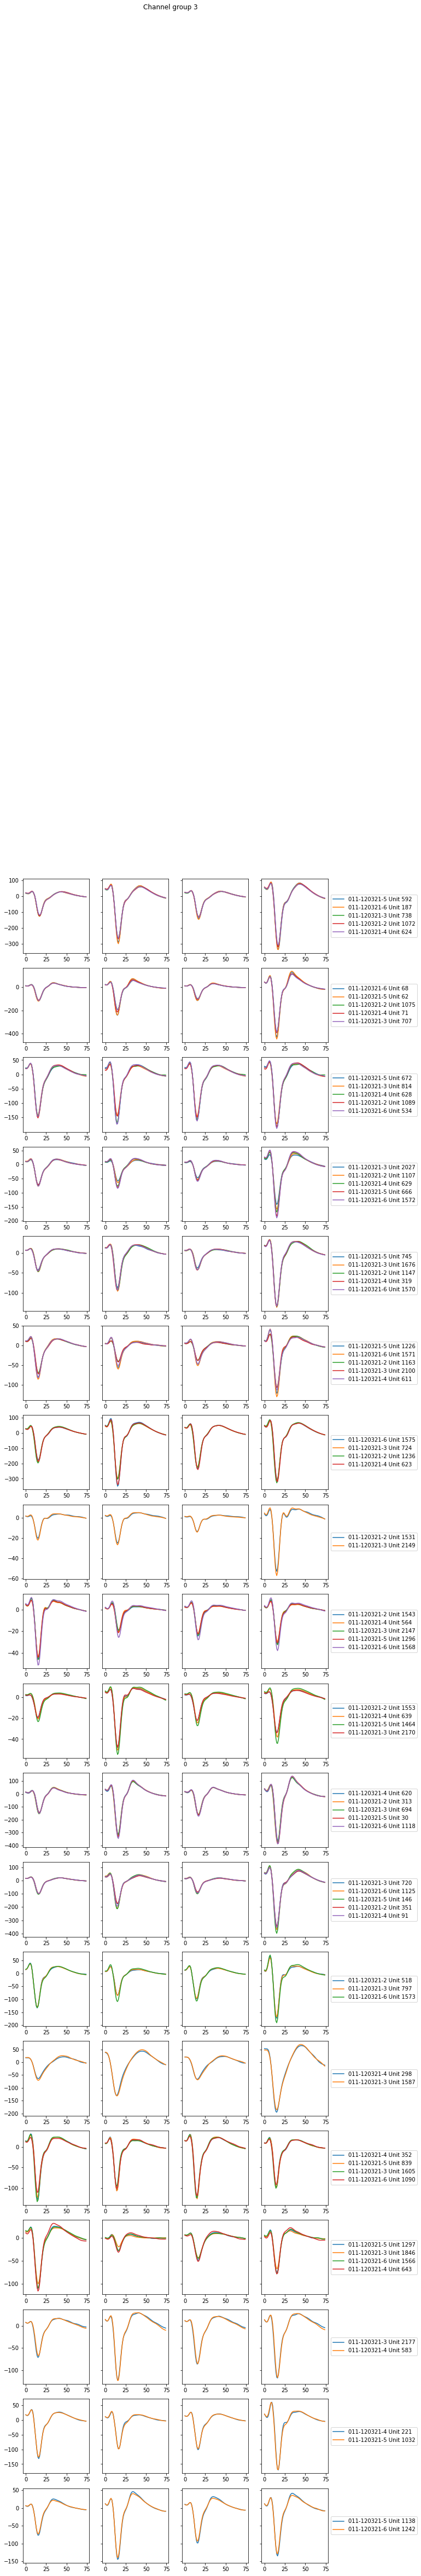

In [14]:
#unit_comp.plot_matches('template', chan_group=1, step_color=False)
unit_comp.plot_matches('template', step_color=False)

#plt.tight_layout()

# Store uniqe unit ids to csv

In [15]:
max_dissimilarity = .05
max_depth_delta = 100
id_nums = {}
num = 0
output = identify_neurons.data_path()

for entity, values in sessions_include.groupby('entity'):
    data_path = output / f'{entity}-graphs'
    unit_matching = TrackMultipleSessions(
        actions, values.action.values.tolist(), 
        progress_bar=tqdm, verbose=False, data_path=data_path
    )
    unit_matching.load_graphs()
    # cutoff large dissimilarities
    unit_matching.remove_edges_above_threshold('weight', max_dissimilarity)
    unit_matching.remove_edges_above_threshold('depth_delta', max_depth_delta)
    unit_matching.remove_edges_with_duplicate_actions()
    unit_matching.identify_units()
    units = []
    for ch, group in unit_matching.identified_units.items():
        for unit_id, val in group.items():
            for action_id, orig_unit_ids in val['original_unit_ids'].items():
                if unit_id not in id_nums:
                    id_nums[unit_id] = num
                    num += 1
                units.extend([
                    {
                        'unit_name': name, 
                        'unit_idnum': id_nums[unit_id],
                        'unit_id': unit_id, 
                        'action': action_id,
                        'channel_group': ch,
                        'max_dissimilarity': max_dissimilarity,
                        'max_depth_delta': max_depth_delta
                    } 
                    for name in orig_unit_ids])
    units = pd.DataFrame(units)
    units = units[~units.action.isin(skip_actions)]
    units.to_csv(output / f'{entity}-units.csv', index=False)

In [16]:
unique_units = pd.concat([
    pd.read_csv(p) 
    for p in output.iterdir() 
    if p.name.endswith('-units.csv')])

In [17]:
unique_units.to_csv(output / 'units.csv', index=False)

# Store results in Expipe action

In [18]:
identify_neurons.data['sessions'] = 'sessions.csv'
identify_neurons.data['units'] = 'units.csv'

In [19]:
copy_tree(output, str(identify_neurons.data_path()))

['/mnt/WD12TB-HDD/data/ca2mec/actions/identify-neurons/data/011-graphs/graph-group-7.yaml',
 '/mnt/WD12TB-HDD/data/ca2mec/actions/identify-neurons/data/011-graphs/graph-group-6.yaml',
 '/mnt/WD12TB-HDD/data/ca2mec/actions/identify-neurons/data/011-graphs/graph-group-4.yaml',
 '/mnt/WD12TB-HDD/data/ca2mec/actions/identify-neurons/data/011-graphs/graph-group-3.yaml',
 '/mnt/WD12TB-HDD/data/ca2mec/actions/identify-neurons/data/011-graphs/graph-group-1.yaml',
 '/mnt/WD12TB-HDD/data/ca2mec/actions/identify-neurons/data/011-graphs/graph-group-5.yaml',
 '/mnt/WD12TB-HDD/data/ca2mec/actions/identify-neurons/data/011-graphs/graph-group-0.yaml',
 '/mnt/WD12TB-HDD/data/ca2mec/actions/identify-neurons/data/011-graphs/graph-group-2.yaml',
 '/mnt/WD12TB-HDD/data/ca2mec/actions/identify-neurons/data/011-units.csv',
 '/mnt/WD12TB-HDD/data/ca2mec/actions/identify-neurons/data/00-identify-neurons.html',
 '/mnt/WD12TB-HDD/data/ca2mec/actions/identify-neurons/data/units.csv',
 '/mnt/WD12TB-HDD/data/ca2mec

In [20]:
store_notebook(
    identify_neurons, "00-identify-neurons.ipynb")

## Load and view results

In [21]:
pd.read_csv(output / "units.csv")

,unit_name,unit_idnum,unit_id,action,channel_group,max_dissimilarity,max_depth_delta
0,414,0,13da002c-9870-42db-87e0-0f6ff9b05bd2,011-120321-4,1,0.05,100
1,1880,0,13da002c-9870-42db-87e0-0f6ff9b05bd2,011-120321-3,1,0.05,100
2,1153,0,13da002c-9870-42db-87e0-0f6ff9b05bd2,011-120321-5,1,0.05,100
3,321,0,13da002c-9870-42db-87e0-0f6ff9b05bd2,011-120321-6,1,0.05,100
4,1248,0,13da002c-9870-42db-87e0-0f6ff9b05bd2,011-120321-2,1,0.05,100
...,...,...,...,...,...,...,...
153,1165,56,7691b357-04fd-4a0c-8943-423347a05f39,011-120321-6,3,0.05,100
154,1495,57,11f6cdb8-378e-4d47-87d2-e5b9199ad34c,011-120321-6,3,0.05,100
155,1567,58,c9f39099-663e-4184-83e2-c06a77c44e36,011-120321-6,3,0.05,100
156,1569,59,53b4e32c-1c6b-49a7-9abc-a32516754f87,011-120321-6,3,0.05,100


In [22]:
pd.read_csv(output / "units.csv")["unit_id"].unique()

array(['13da002c-9870-42db-87e0-0f6ff9b05bd2',
       '362b87d9-b8cd-4ac9-bf7c-c00826ac5b19',
       '8667910b-a776-40e3-9512-ab252847a9a2',
       'df77a533-295b-4861-a584-af07665509bf',
       'c930fa88-5f5f-499a-a793-56ae354f361d',
       'cb7c405a-c65e-4f34-acfd-db341c9f9bdc',
       '1a6beb85-8611-404b-9994-627e1fd30e9e',
       '35eea67f-545f-4114-aa21-4f0e45fb94eb',
       'a12b5b5c-bc3b-4669-bd8f-5f58013f008a',
       'e2d959f0-40bc-42b8-9c62-f982ae0fa2d5',
       '7c4b7b9a-74f7-46b4-b01f-5d12b0067997',
       'b0c8dffc-8a45-4187-8eaa-7d409a3fcd33',
       'c913113d-8e6a-4e1e-959b-12c4abdcadab',
       'dbd98914-7ac4-4f50-8cad-8f62299b0c59',
       'f94eda1b-2a09-4a68-b623-27971499b6e4',
       'e3ef1846-34d7-475b-a654-3556b6ce9803',
       '208af5c0-8746-4964-b87f-b05e7308541b',
       '5d943037-5365-4a66-b89d-6a3a1f268d4c',
       'b0bf33ed-4d6c-4164-8145-632b9fc250ef',
       '9f4e009d-5f85-42d0-88eb-d507c50255e8',
       'fa66e75b-3745-4bb9-847a-c9a3399adca1',
       '04136